In [31]:
# Tugas 1
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Tugas1").getOrCreate()

25/10/29 16:25:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [32]:
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [33]:
# Tugas 2
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



In [34]:
# Tugas Tambahan 2 NO 1
spark.sql('''
SELECT DeptId, AVG(Salary) as AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').show()

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [35]:
# Tugas Tambahan 2 NO 2
spark.sql('''
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN (
    SELECT Gender, AVG(Salary) as AvgSalary
    FROM employees
    GROUP BY Gender
) g
ON e.Gender = g.Gender
WHERE e.Salary > g.AvgSalary
ORDER BY e.Gender, e.Salary DESC
''').show()

+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+



In [36]:
# Tugas Tambahan 2 NO 3
from pyspark.sql.window import Window
import pyspark.sql.functions as F

windowDept = Window.partitionBy('DeptId').orderBy(F.desc('Salary'))

employees_with_rank = spark.table('employees').withColumn('Rank', F.rank().over(windowDept))
employees_with_rank.show()

+-----+---+------+------+------+----+
| Name|Age|Gender|Salary|DeptId|Rank|
+-----+---+------+------+------+----+
|James| 34|     M|  3000|     1|   1|
|  Lee| 23|     M|  2700|     1|   2|
| Anna| 28|     F|  4100|     2|   1|
+-----+---+------+------+------+----+



In [37]:
# Tugas 3
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [38]:
# Tugas 4
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

25/10/29 16:25:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



In [39]:
# Tugas 5
spark.sql('''
SELECT e.Name, e.Salary, d.DeptName, 
       AVG(e.Salary) OVER (PARTITION BY d.DeptName) as AvgDeptSalary,
       RANK() OVER (PARTITION BY d.DeptName ORDER BY e.Salary DESC) as DeptRank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY d.DeptName, DeptRank
''').show()

+-----+------+---------+-------------+--------+
| Name|Salary| DeptName|AvgDeptSalary|DeptRank|
+-----+------+---------+-------------+--------+
|James|  3000|       HR|       2850.0|       1|
|  Lee|  2700|       HR|       2850.0|       2|
| Anna|  4100|Marketing|       4100.0|       1|
+-----+------+---------+-------------+--------+



In [40]:
# Tugas 6
spark.sql('''
SELECT e.Name, e.Age, e.Salary, d.DeptName,
       AVG(e.Salary) OVER (PARTITION BY d.DeptName, e.Age) as AvgSalaryByAgeDept
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY d.DeptName, e.Age
''').show()

+-----+---+------+---------+------------------+
| Name|Age|Salary| DeptName|AvgSalaryByAgeDept|
+-----+---+------+---------+------------------+
|  Lee| 23|  2700|       HR|            2700.0|
|James| 34|  3000|       HR|            3000.0|
| Anna| 28|  4100|Marketing|            4100.0|
+-----+---+------+---------+------------------+



In [41]:
# Tugas 7
!pip install matplotlib pandas

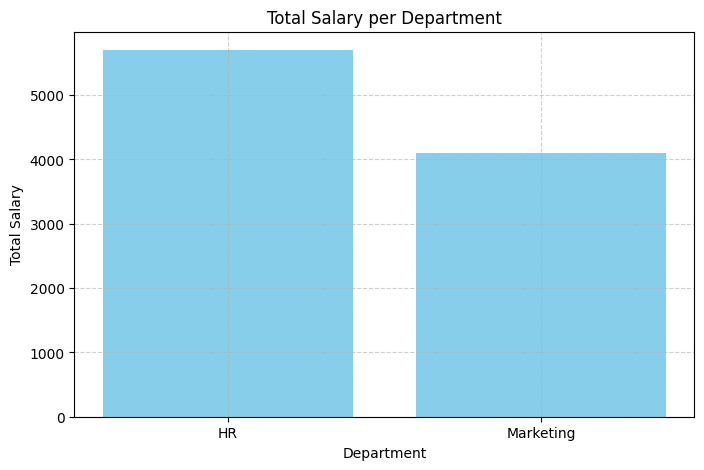

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

dept_summary = spark.sql('''
SELECT d.DeptName,
       SUM(e.Salary) AS TotalSalary,
       COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalSalary DESC
''').toPandas()

plt.figure(figsize=(8, 5))
plt.bar(dept_summary['DeptName'], dept_summary['TotalSalary'], color='skyblue')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [43]:
# Homework
!pip install pyspark matplotlib pandas

In [44]:
# Import library
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import random

# Inisialisasi spark session
spark = SparkSession.builder.appName("Homework_Hands-On9").getOrCreate()

# Membuat data
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Sara', 29, 'F', 3900, 2),
    ('Tom', 31, 'M', 3500, 3),
    ('John', 28, 'M', 4500, 3),
    ('Maya', 34, 'F', 5000, 1),
    ('Lia', 25, 'F', 2900, 2),
    ('Rob', 31, 'M', 3700, 3),
    ('Kira', 27, 'F', 3400, 1),
    ('Alan', 30, 'M', 4200, 4), 
    ('Bella', 26, 'F', 3800, 4), 
    ('Chris', 32, 'M', 4100, 5), 
    ('Diana', 29, 'F', 4000, 5)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing'),
    (3, 'Finance'),
    (4, 'Sales'),
    (5, 'Operations')
], ['DeptId', 'DeptName'])

# Mendaftarkan tabel temporer
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')

# Cek data
print("=== Data Employees ===")
employees.show()
print("=== Data Departments ===")
departments.show()

25/10/29 16:26:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


=== Data Employees ===
+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
| Sara| 29|     F|  3900|     2|
|  Tom| 31|     M|  3500|     3|
| John| 28|     M|  4500|     3|
| Maya| 34|     F|  5000|     1|
|  Lia| 25|     F|  2900|     2|
|  Rob| 31|     M|  3700|     3|
| Kira| 27|     F|  3400|     1|
| Alan| 30|     M|  4200|     4|
|Bella| 26|     F|  3800|     4|
|Chris| 32|     M|  4100|     5|
|Diana| 29|     F|  4000|     5|
+-----+---+------+------+------+

=== Data Departments ===
+------+----------+
|DeptId|  DeptName|
+------+----------+
|     1|        HR|
|     2| Marketing|
|     3|   Finance|
|     4|     Sales|
|     5|Operations|
+------+----------+



Total Gaji & Jumlah Karyawan per Departemen
+----------+-----------+-------------+
|  DeptName|TotalSalary|EmployeeCount|
+----------+-----------+-------------+
|        HR|      14100|            4|
|   Finance|      11700|            3|
| Marketing|      10900|            3|
|Operations|       8100|            2|
|     Sales|       8000|            2|
+----------+-----------+-------------+



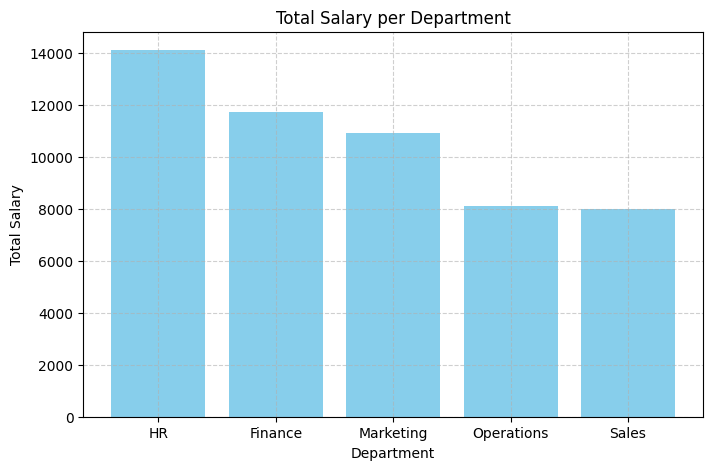

In [45]:
# Homework 1
dept_summary = spark.sql('''
SELECT d.DeptName,
       SUM(e.Salary) AS TotalSalary,
       COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalSalary DESC
''')

print("Total Gaji & Jumlah Karyawan per Departemen")
dept_summary.show()

df1 = dept_summary.toPandas()
plt.figure(figsize=(8,5))
plt.bar(df1['DeptName'], df1['TotalSalary'], color='skyblue')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Karyawan dengan Gaji di Atas Rata-rata Usianya
+-----+---+------+
| Name|Age|Salary|
+-----+---+------+
| John| 28|  4500|
|Diana| 29|  4000|
|  Rob| 31|  3700|
| Maya| 34|  5000|
+-----+---+------+



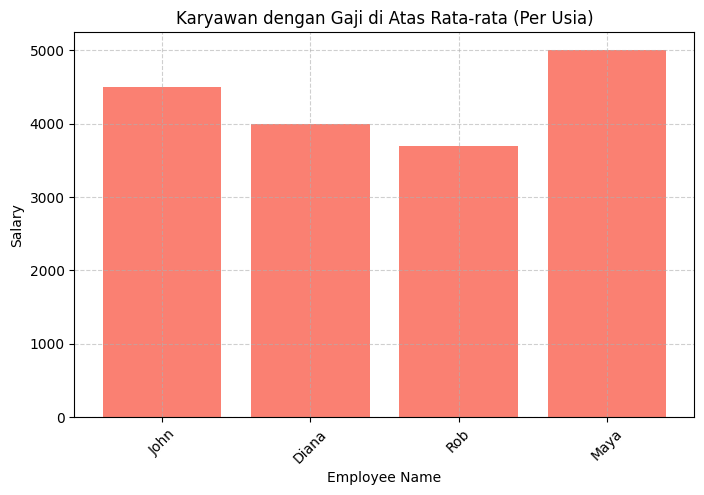

In [46]:
# Homework 2
above_avg_age = spark.sql('''
SELECT e.Name, e.Age, e.Salary
FROM employees e
JOIN (
    SELECT Age, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Age
) a ON e.Age = a.Age
WHERE e.Salary > a.AvgSalary
ORDER BY e.Age
''')

print("Karyawan dengan Gaji di Atas Rata-rata Usianya")
above_avg_age.show()

df2 = above_avg_age.toPandas()
plt.figure(figsize=(8,5))
plt.bar(df2['Name'], df2['Salary'], color='salmon')
plt.xticks(rotation=45)
plt.xlabel('Employee Name')
plt.ylabel('Salary')
plt.title('Karyawan dengan Gaji di Atas Rata-rata (Per Usia)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [47]:
# Homework 3
!pip install pyspark pandas matplotlib

In [48]:
# Import Library
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

# Inisialisasi Spark
spark = SparkSession.builder.appName("Homework_3").getOrCreate()

# Membuat tabel depatment dan project
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing'),
    (3, 'Finance'),
    (4, 'Sales'),
    (5, 'Operations'),
    (6, 'IT')
], ['DeptId', 'DeptName'])
departments.createOrReplaceTempView('departments')

projects = spark.createDataFrame([
    (1, 'Talent Acquisition'),
    (1, 'HRIS Migration'),
    (2, 'Brand Campaign'),
    (2, 'Social Media Growth'),
    (3, 'Audit 2025'),
    (4, 'Retail Expansion'),
    (5, 'Logistics Optimization'),
    (6, 'Platform Upgrade'),
    (6, 'Security Hardening')
], ['DeptId', 'ProjectName'])
projects.createOrReplaceTempView('projects')

# Membuat employees besar
random.seed(42)
names = ['Aditya','Bima','Citra','Deka','Eka','Fajar','Gita','Hadi','Ika','Joko',
         'Kiki','Lina','Mira','Nico','Oki','Putu','Rina','Sari','Tono','Ucup',
         'Vina','Wido','Xena','Yudha','Zara']
genders = ['M','F']
dept_ids = [1,2,3,4,5,6]

big_data = []
for i in range(1, 151): 
    name = random.choice(names) + f"_{i}"
    age = random.randint(22, 55)
    gender = random.choice(genders)
    dept = random.choice(dept_ids)
    base = random.randint(2500, 7000)
    if dept in (3,6): 
        salary = base + random.randint(500, 3000)
    else:
        salary = base
    big_data.append((name, age, gender, int(salary), int(dept)))

employees_big = spark.createDataFrame(big_data, ['Name','Age','Gender','Salary','DeptId'])
employees_big.createOrReplaceTempView('employees_big')

# Menampilkan data dalam jumlah tertentu
print("Data 15 baris dari employees_big:")
employees_big.show(15, truncate=False)

Data 15 baris dari employees_big:
+--------+---+------+------+------+
|Name    |Age|Gender|Salary|DeptId|
+--------+---+------+------+------+
|Vina_1  |29 |M     |6256  |6     |
|Hadi_2  |30 |M     |7823  |6     |
|Tono_3  |49 |M     |3267  |1     |
|Gita_4  |36 |M     |4128  |5     |
|Xena_5  |48 |M     |4778  |4     |
|Aditya_6|32 |F     |5912  |3     |
|Gita_7  |43 |M     |5612  |1     |
|Deka_8  |44 |F     |4666  |5     |
|Bima_9  |51 |M     |3145  |4     |
|Sari_10 |40 |F     |4075  |5     |
|Xena_11 |26 |M     |6051  |6     |
|Citra_12|36 |M     |4777  |4     |
|Oki_13  |45 |M     |6768  |3     |
|Wido_14 |39 |M     |3901  |5     |
|Sari_15 |37 |M     |5608  |4     |
+--------+---+------+------+------+
only showing top 15 rows


25/10/29 16:26:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [49]:
sum_salary = spark.sql('''
SELECT d.DeptName, SUM(e.Salary) AS TotalSalary
FROM employees_big e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalSalary DESC
''')
print("TOTAL GAJI PER DEPARTEMEN")
sum_salary.show(truncate=False)

TOTAL GAJI PER DEPARTEMEN
+----------+-----------+
|DeptName  |TotalSalary|
+----------+-----------+
|IT        |175129     |
|Finance   |173388     |
|Sales     |135706     |
|HR        |124283     |
|Operations|123333     |
|Marketing |83966      |
+----------+-----------+



In [50]:
avg_salary = spark.sql('''
SELECT d.DeptName, ROUND(AVG(e.Salary),2) AS AvgSalary
FROM employees_big e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY AvgSalary DESC
''')
print("RATA-RATA GAJI PER DEPARTEMEN")
avg_salary.show(truncate=False)

RATA-RATA GAJI PER DEPARTEMEN
+----------+---------+
|DeptName  |AvgSalary|
+----------+---------+
|IT        |6735.73  |
|Finance   |6421.78  |
|Marketing |5247.88  |
|Operations|4933.32  |
|Sales     |4679.52  |
|HR        |4603.07  |
+----------+---------+



In [51]:
count_emp = spark.sql('''
SELECT d.DeptName, COUNT(e.Name) AS EmployeeCount
FROM employees_big e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY EmployeeCount DESC
''')
print("JUMLAH KARYAWAN PER DEPARTEMEN")
count_emp.show(truncate=False)

JUMLAH KARYAWAN PER DEPARTEMEN
+----------+-------------+
|DeptName  |EmployeeCount|
+----------+-------------+
|Sales     |29           |
|HR        |27           |
|Finance   |27           |
|IT        |26           |
|Operations|25           |
|Marketing |16           |
+----------+-------------+



In [52]:
join_table = spark.sql('''
SELECT e.Name, e.Age, e.Gender, e.Salary, d.DeptName
FROM employees_big e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY d.DeptName, e.Name
LIMIT 15
''')
print("GABUNGAN DATA EMPLOYEES DENGAN DEPARTEMEN")
join_table.show(truncate=False)

GABUNGAN DATA EMPLOYEES DENGAN DEPARTEMEN
+---------+---+------+------+--------+
|Name     |Age|Gender|Salary|DeptName|
+---------+---+------+------+--------+
|Aditya_6 |32 |F     |5912  |Finance |
|Aditya_81|55 |M     |6819  |Finance |
|Bima_112 |38 |F     |6595  |Finance |
|Bima_17  |42 |F     |4406  |Finance |
|Citra_60 |37 |F     |6086  |Finance |
|Deka_80  |46 |M     |5149  |Finance |
|Eka_69   |24 |F     |4791  |Finance |
|Gita_118 |51 |F     |6855  |Finance |
|Gita_70  |37 |M     |6962  |Finance |
|Hadi_38  |26 |M     |5685  |Finance |
|Hadi_74  |34 |F     |6432  |Finance |
|Ika_76   |26 |F     |8810  |Finance |
|Joko_141 |28 |M     |6341  |Finance |
|Kiki_113 |43 |F     |7486  |Finance |
|Kiki_128 |37 |M     |7690  |Finance |
+---------+---+------+------+--------+

